# Processing Pipeline for `spRNA-seq` Data

This notebook presents a spatial transcriptomics data analysis pipeline. The
input data were obtained from GEO: GSE158328.

In [1]:
# Edit the variable below to point at a valid MEX scRNA-seq dataset.
dataset_filepath = "../data/fawkner-corbett-st-a1"

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import squidpy as sq

sc.settings.set_figure_params(dpi=100, facecolor="white")

In [3]:
data = sq.read.visium(dataset_filepath)
data.var_names_make_unique()

d:\uqam\bif7104\easy-st\venv\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
d:\uqam\bif7104\easy-st\venv\Lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


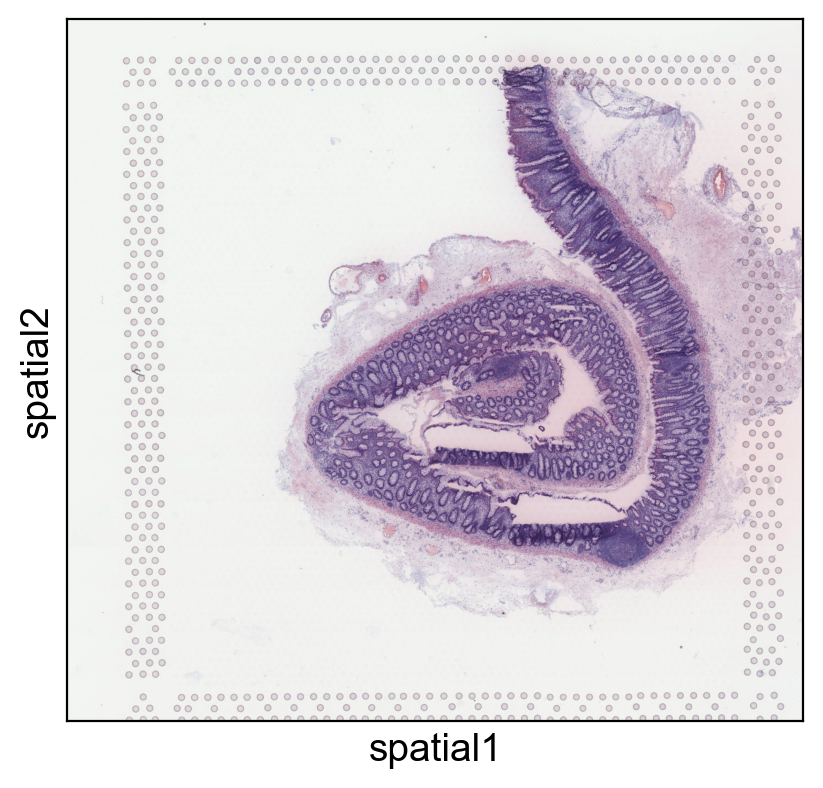

In [22]:
sq.pl.spatial_scatter(data)

In [4]:
scale = data.uns['spatial']['A1_results']['scalefactors']['tissue_hires_scalef']
img = sq.im.ImageContainer(data.uns['spatial']['A1_results']['images']['hires'],
                           scale=scale, library_id='A1_results')
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        data,
        img,
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
data.obsm["features"] = pd.concat(
    [data.obsm[f] for f in data.obsm.keys() if "features_summary" in f],
    axis="columns",
)
# make sure that we have no duplicated feature names in the combined table
data.obsm["features"].columns = ad.utils.make_index_unique(
    data.obsm["features"].columns
)

  0%|          | 0/2649 [00:00<?, ?/s]

  0%|          | 0/2649 [00:00<?, ?/s]

C:\Users\vince\AppData\Local\Temp\ipykernel_1892\1665796575.py:18: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(data)
d:\uqam\bif7104\easy-st\venv\Lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


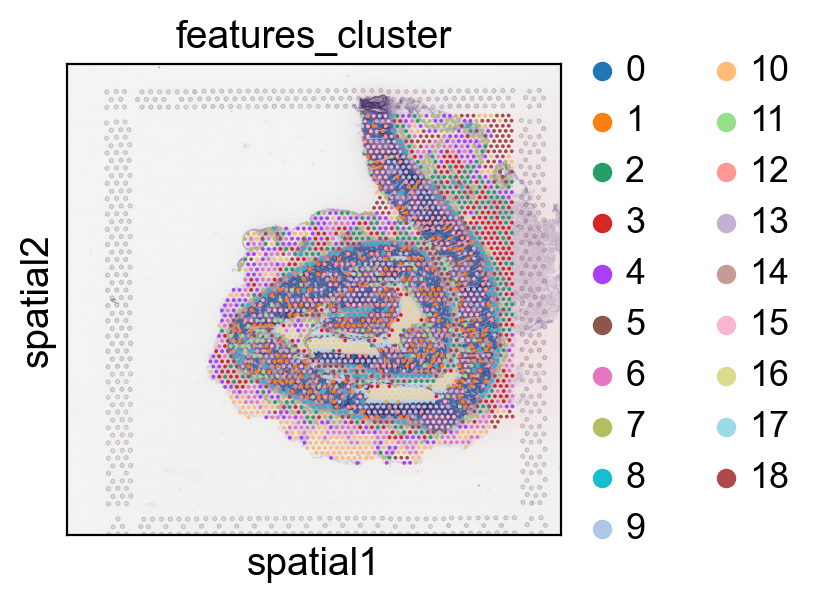

In [5]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    data = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(data)
    # calculate leiden clustering
    sc.pp.pca(data, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(data)
    sc.tl.leiden(data)

    return data.obs["leiden"]


# calculate feature clusters
data.obs["features_cluster"] = cluster_features(data.obsm["features"], like="summary")

# compare feature and gene clusters
sq.pl.spatial_scatter(data, color=["features_cluster"])

  0%|          | 0/1000 [00:00<?, ?/s]

d:\uqam\bif7104\easy-st\venv\Lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
d:\uqam\bif7104\easy-st\venv\Lib\site-packages\squidpy\pl\_utils.py:557: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row_labels = adata.obs[key][row_order]


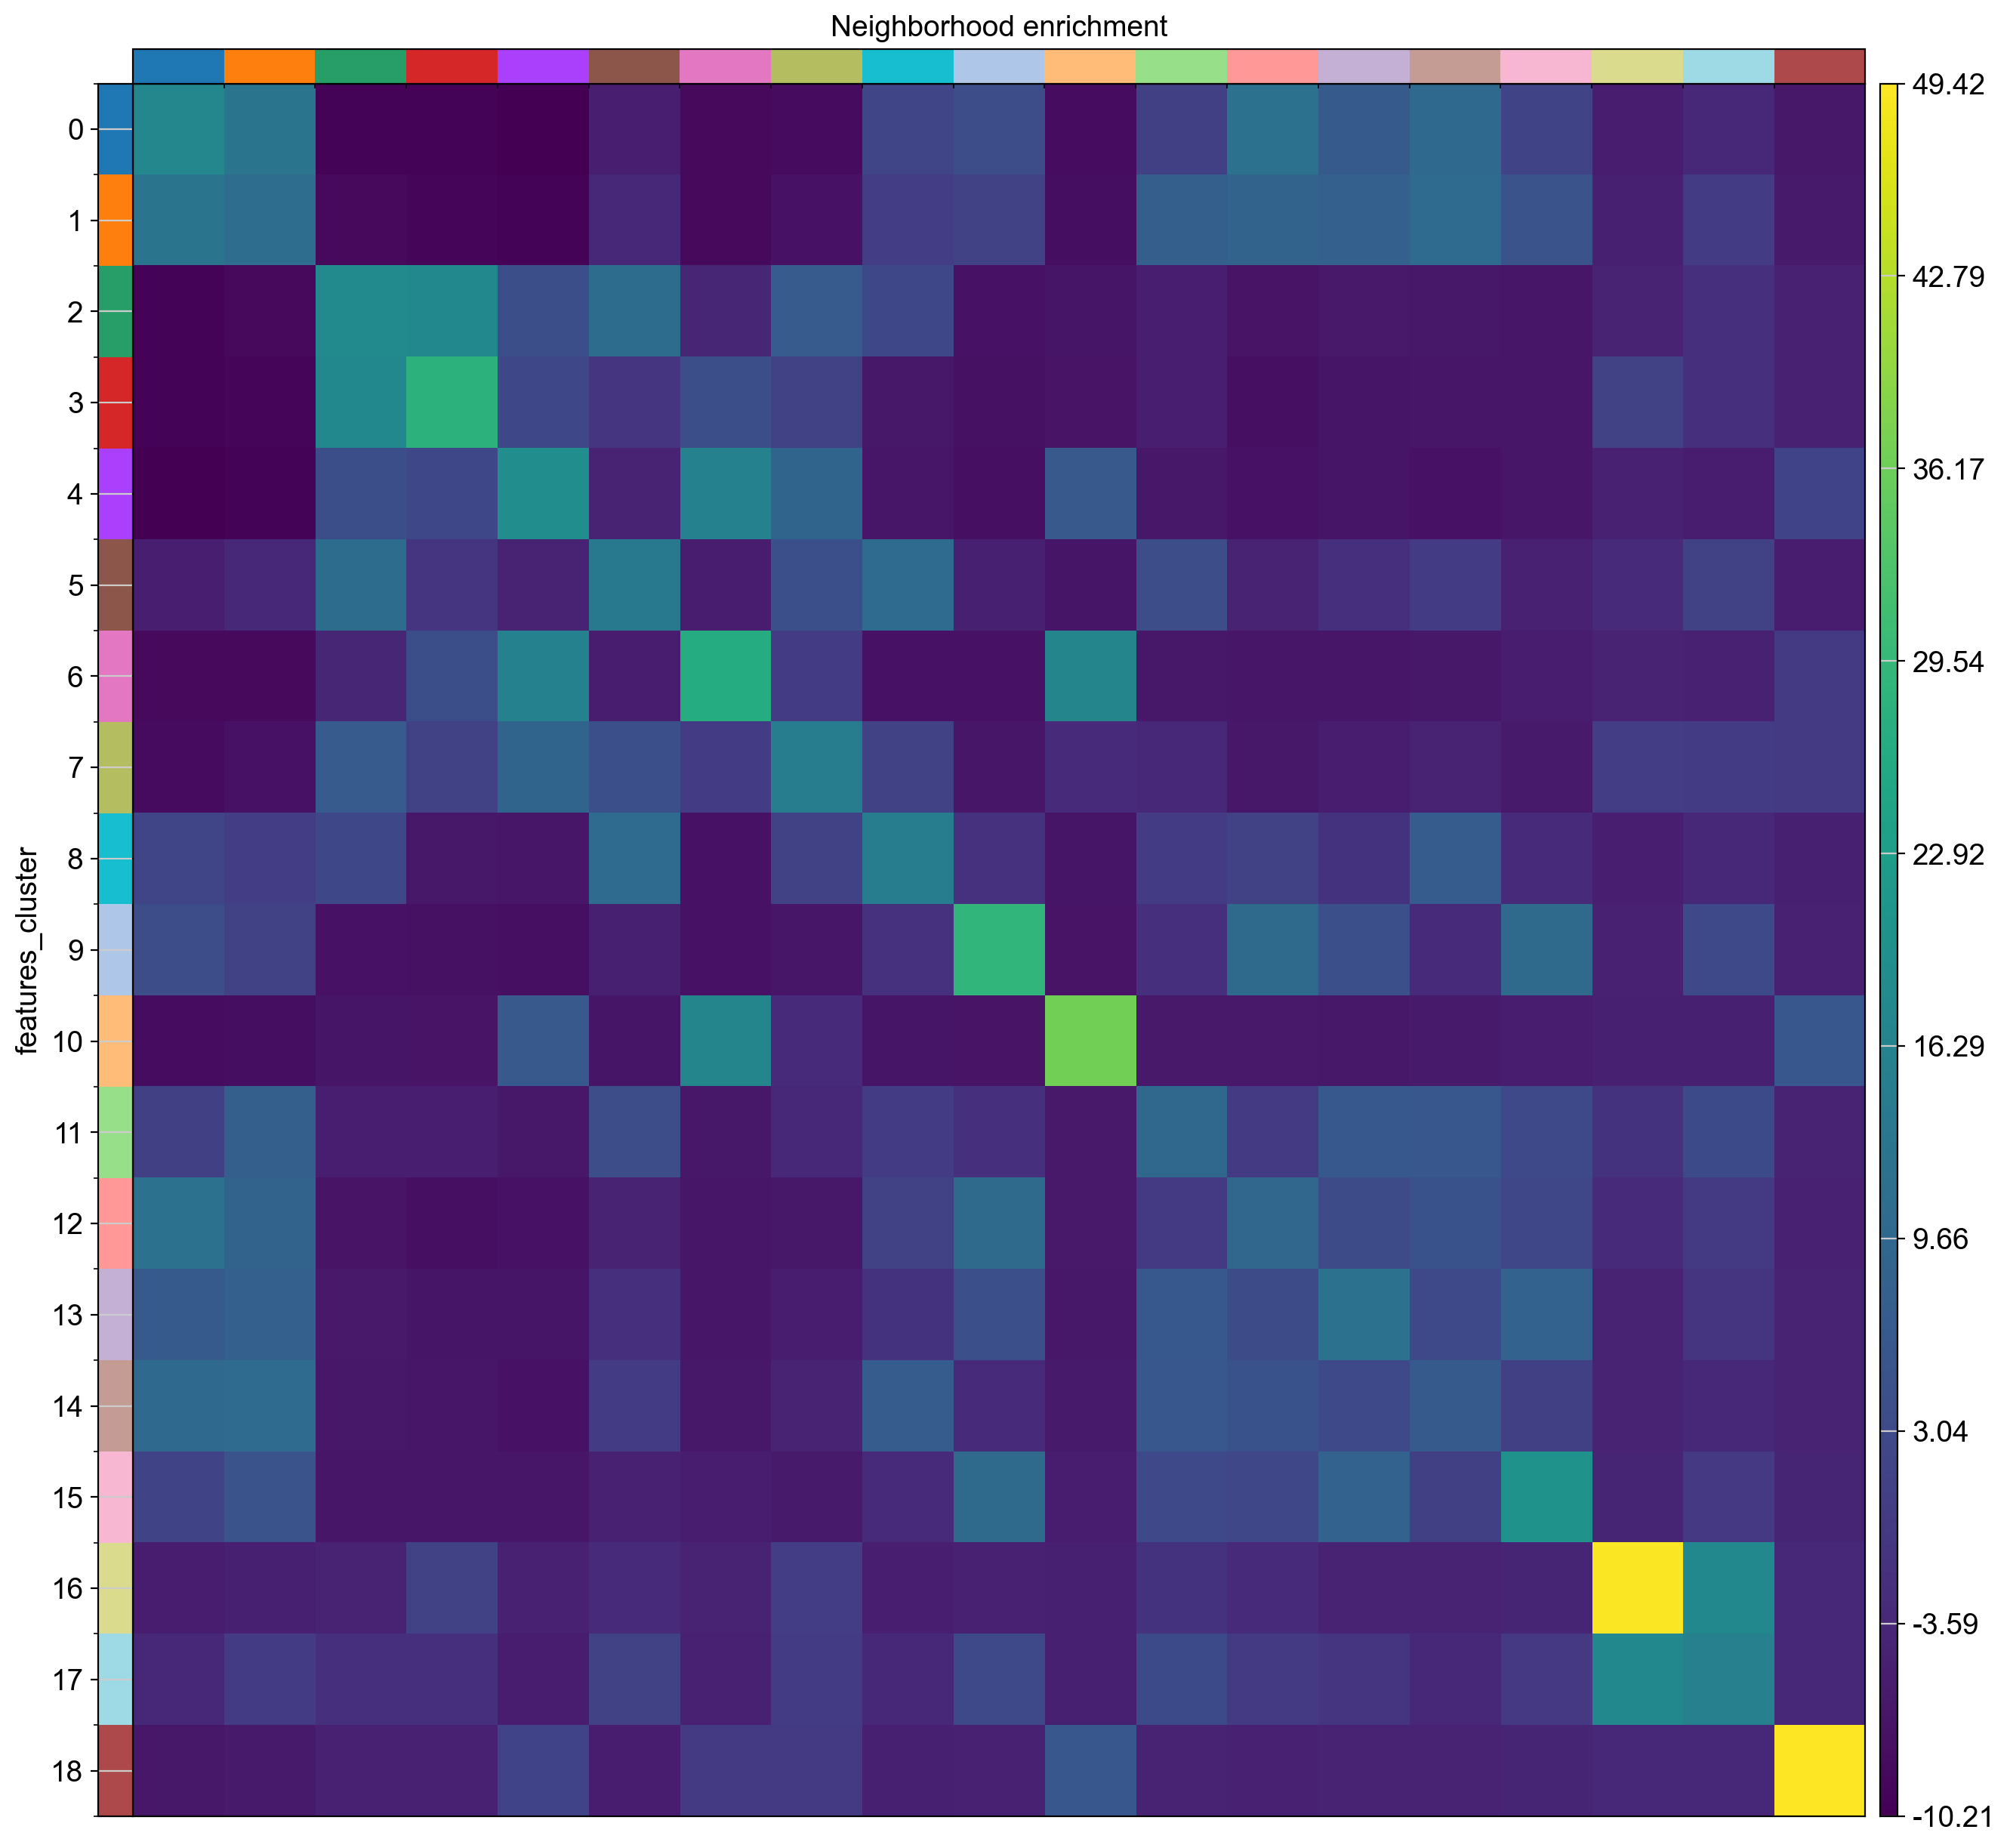

In [6]:
sq.gr.spatial_neighbors(data)
sq.gr.nhood_enrichment(data, cluster_key="features_cluster")
sq.pl.nhood_enrichment(data, cluster_key="features_cluster")

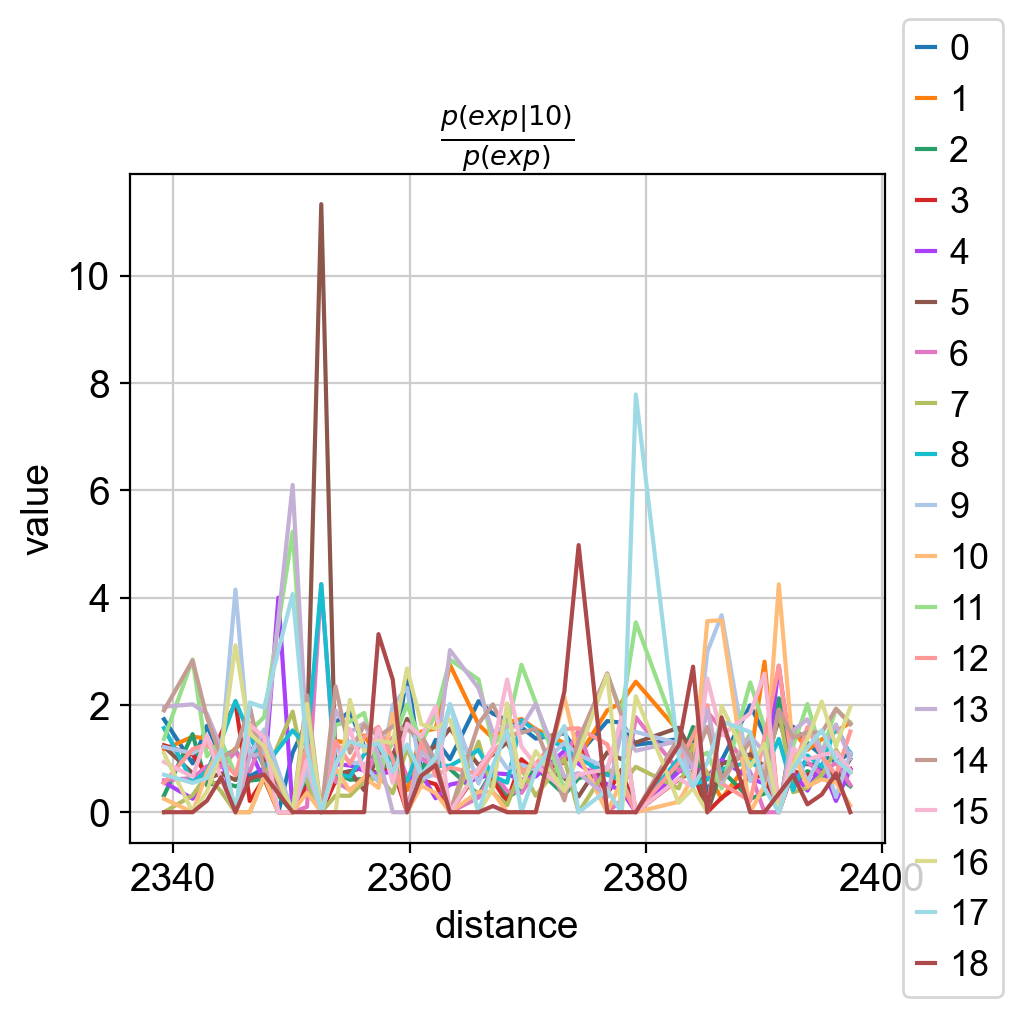

In [14]:
sq.gr.co_occurrence(data, cluster_key="features_cluster")
sq.pl.co_occurrence(
    data,
    cluster_key="features_cluster",
    clusters='10',
)

d:\uqam\bif7104\easy-st\venv\Lib\site-packages\squidpy\pl\_ligrec.py:306: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  for cls, size in (pvals.groupby(level=0, axis=1)).size().to_dict().items():
d:\uqam\bif7104\easy-st\venv\Lib\site-packages\anndata\_core\anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


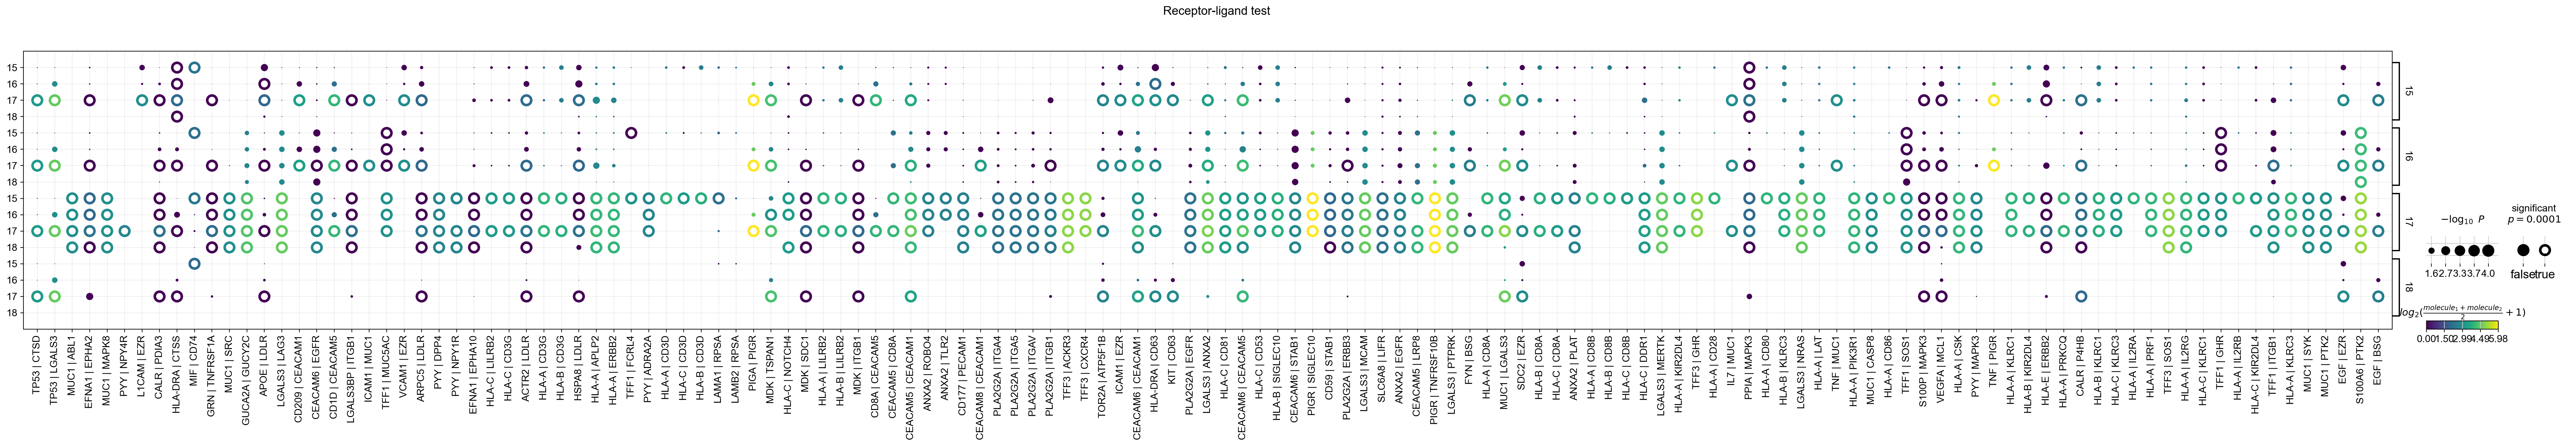

In [18]:
sq.gr.ligrec(
    data,
    n_perms=100,
    cluster_key="features_cluster",
    use_raw=False
)
sq.pl.ligrec(
    data,
    cluster_key="features_cluster",
    means_range=(3, np.inf),
    alpha=1e-4,
    swap_axes=True,
)

In [19]:
genes = data.var["gene_ids"].keys()[:1000]
sq.gr.spatial_autocorr(
    data,
    mode="moran",
    genes=genes,
    n_perms=100,
    n_jobs=1,
)
data.uns["moranI"].head(10)

d:\uqam\bif7104\easy-st\venv\Lib\site-packages\scanpy\metrics\_common.py:62: UserWarning: 296 variables were constant, will return nan for these.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?/s]

I  pval_norm  var_norm  pval_z_sim  pval_sim   var_sim  \
CD52      0.712952        0.0  0.000131         0.0  0.009901  0.000283   
LAPTM5    0.602563        0.0  0.000131         0.0  0.009901  0.000321   
RPS8      0.520886        0.0  0.000131         0.0  0.009901  0.000165   
GUCA2A    0.498757        0.0  0.000131         0.0  0.009901  0.000204   
RPL11     0.478794        0.0  0.000131         0.0  0.009901  0.000198   
RPL22     0.469220        0.0  0.000131         0.0  0.009901  0.000160   
HMGN2     0.457796        0.0  0.000131         0.0  0.009901  0.000187   
SFN       0.431176        0.0  0.000131         0.0  0.009901  0.000193   
TMEM54    0.428443        0.0  0.000131         0.0  0.009901  0.000155   
SH3BGRL3  0.426717        0.0  0.000131         0.0  0.009901  0.000178   

          pval_norm_fdr_bh  pval_z_sim_fdr_bh  pval_sim_fdr_bh  
CD52                   NaN                NaN         0.015093  
LAPTM5                 NaN                NaN         0.015093  
RPS8                   NaN                NaN         0.015093  
GUCA2A                 NaN                NaN         0.015093  
RPL11                  NaN                NaN         0.015093  
RPL22                  NaN                NaN         0.015093  
HMGN2                  NaN                NaN         0.015093  
SFN                    NaN                NaN         0.015093  
TMEM54                 NaN                NaN         0.015093  
SH3BGRL3               NaN                NaN         0.015093

d:\uqam\bif7104\easy-st\venv\Lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
d:\uqam\bif7104\easy-st\venv\Lib\site-packages\squidpy\pl\_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)


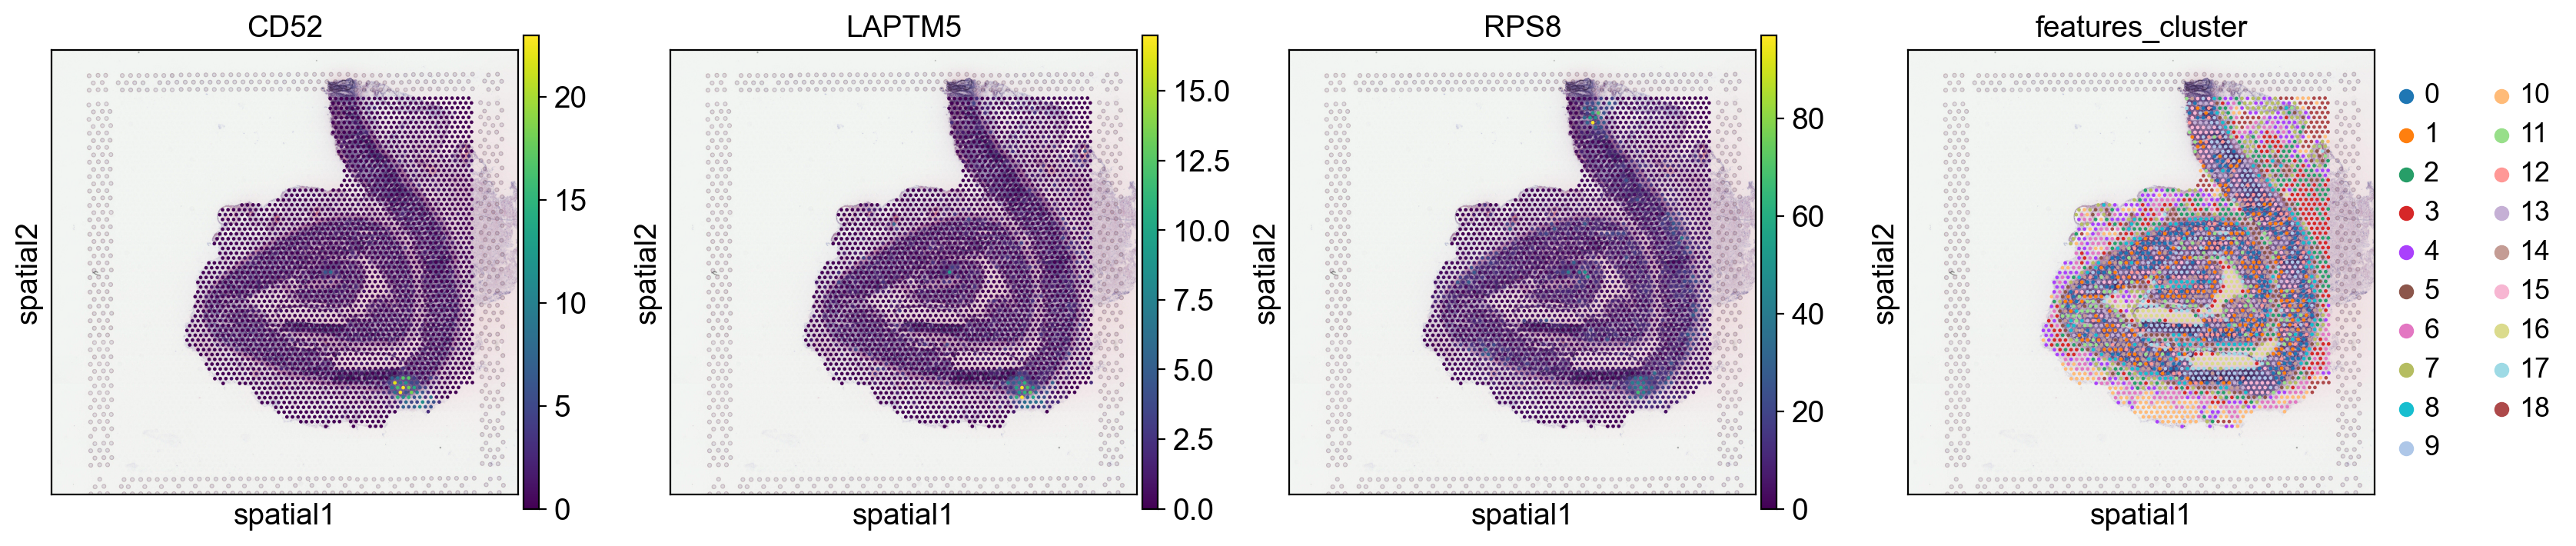

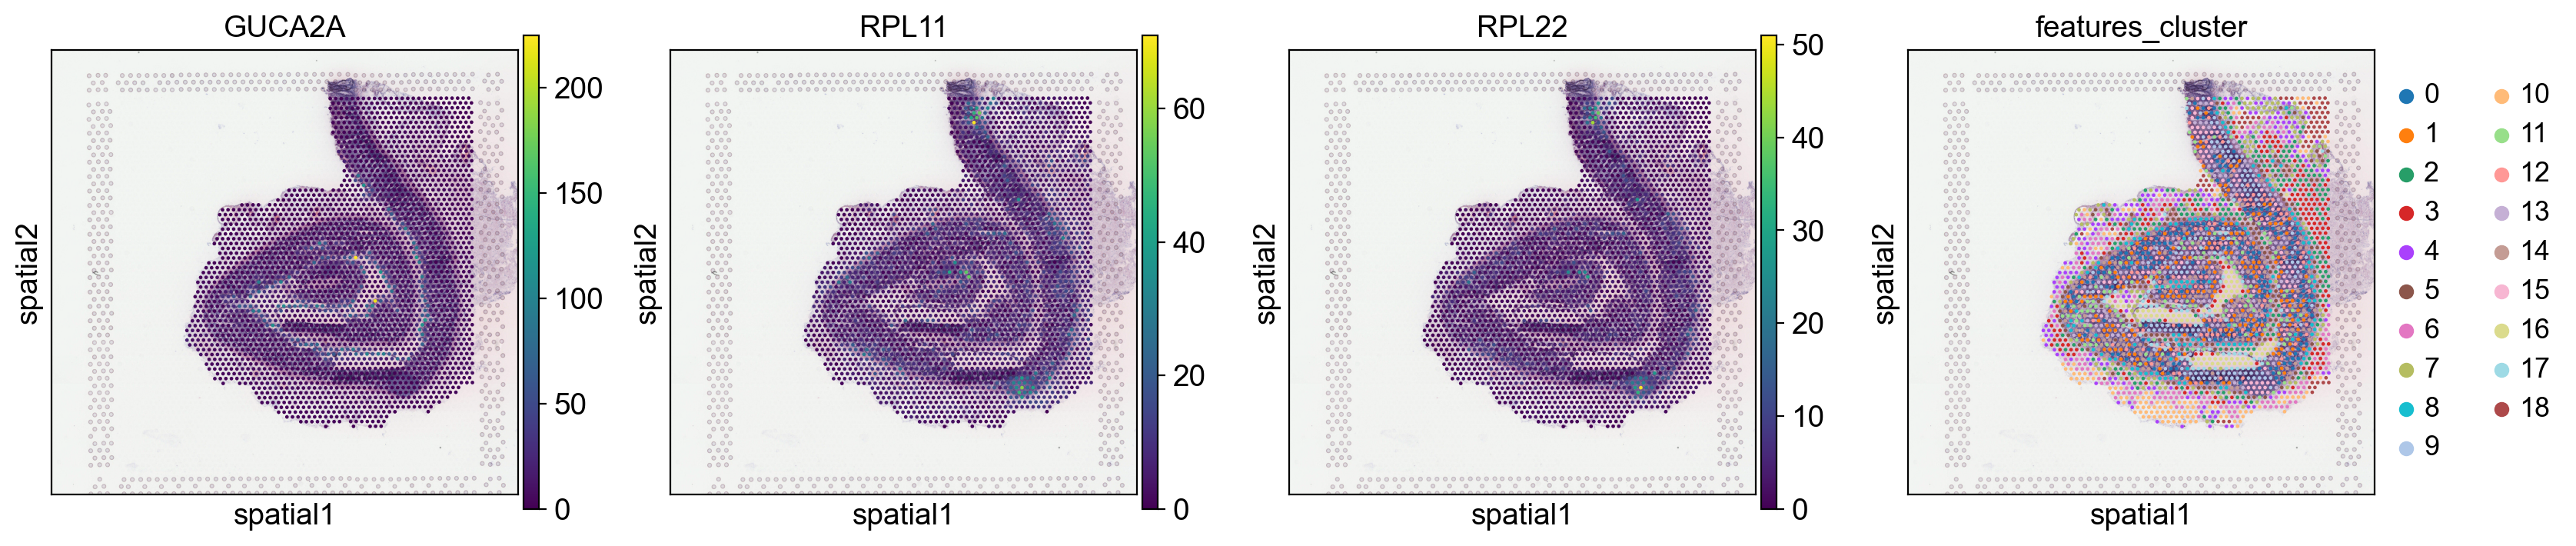

In [20]:
sq.pl.spatial_scatter(data, color=["CD52", "LAPTM5", "RPS8", "features_cluster"])
sq.pl.spatial_scatter(data, color=["GUCA2A", "RPL11", "RPL22", "features_cluster"])